# <center> <font face="Times New Roman" size=8> Time-Series Forecasting Based on Trend and Seasonal components </font> </center>
## <center> <font face="Times New Roman" color=#A9A9A9 size=6> <i>Analyzing the trend and seasonality of the time-series to decompose the time-series and implement forecasting models</i> </font> </center>
## <center> <font face="Times New Roman" size=6> Zhu Lei </font> </center>
---

* <font face="Times New Roman" size=5>Introduction </font><br>
<br>
  <font face="Times New Roman" size=4>Time-series forecasting is the task of making predictions based on time-stamped historical data. It involves building models to make observations and drive future decision-making in applications such as weather, engineering, economics, finance, or business forecasting, among others.<br>
  This article is intended as an introduction to time-series forecasting. The structure unfolds as follows. Firstly, a description of the two main patterns (trend and seasonality) of any time-series. Secondly, a decomposition of the time-series based on those patterns. Lastly, an implementation of a forecasting model called Holt-Winters’ Seasonal Method that is suitable for time-series data with the trend and/or seasonal components.<br>
  To cover all this content, I have created a dataset that simulates the temperatures of a northern hemisphere city such as Sevilla between 2010 and 2020. Both the synthetic dataset and the method used to create it are freely available to anyone interested. The code can be found in the following GitHub repository.
---

* <font face="Times New Roman" size=5> Importing the libraries and the data </font><br>
<br>
<font face="Times New Roman" size=4> Firstly, import the following libraries needed to run the code. </font>

In [2]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.api import ExponentialSmoothing
%matplotlib inline

<font face="Times New Roman" size=4> Here is the code to create the dataset. The data consist of two columns, one for the dates and the other for the temperature between 2011 and 2021.

In [3]:
# date
numdays = 365*10 + 1
base = '2012-01-01'
base = datetime.strptime(base, '%Y-%m-%d')
date_list = [base + timedelta(days=x) for x in range(numdays)]
date_list = np.array(date_list)
print(len(date_list), date_list[0], date_list[-1])

# temp
x = np.linspace(-np.pi, np.pi, 365)
temp_year = (np.sin(x) + 1.0) * 15
x = np.linspace(-np.pi, np.pi, 366)
temp_leap_year = (np.sin(x) + 1.0)
temp_s = []
for i in range(2012, 2022):
    if i == 2012:
        temp_s = temp_year + np.random.rand(365) * 20
    elif i in [2012, 2016]:
        temp_s = np.concatenate((temp_s, temp_leap_year * 15 + np.random.rand(366) * 20 + i % 2012))
    else:
        temp_s = np.concatenate((temp_s, temp_year + np.random.rand(365) * 20 + i % 2012))
print(len(temp_s))

# df
data = np.concatenate((date_list.reshape(-1, 1), temp_s.reshape(-1, 1)), axis=1)
df_orig = pd.DataFrame(data, columns=['date', 'temp'])
df_orig['date'] =  pd.to_datetime(df_orig['date'], format='%Y-%m-%d')
df = df_orig.set_index('date')
df.sort_index(inplace=True)
df

3651 2012-01-01 00:00:00 2021-12-29 00:00:00
3651


,temp
date,
2012-01-01,33.114188
2012-01-02,20.271358
2012-01-03,21.678536
2012-01-04,24.179975
2012-01-05,28.003957
...,...
2021-12-25,44.624421
2021-12-26,36.240948
2021-12-27,41.267948


---

* <font face="Times New Roman" size=5> Visualizing the Dataset </font><br>
<br>
<font face="Times New Roman" size=4> Before we begin to analyze the patterns of the time-series, let’s visualize the data where each vertical dashed line corresponds to the start of the year. </font>

Text(0, 0.5, 'temperature')

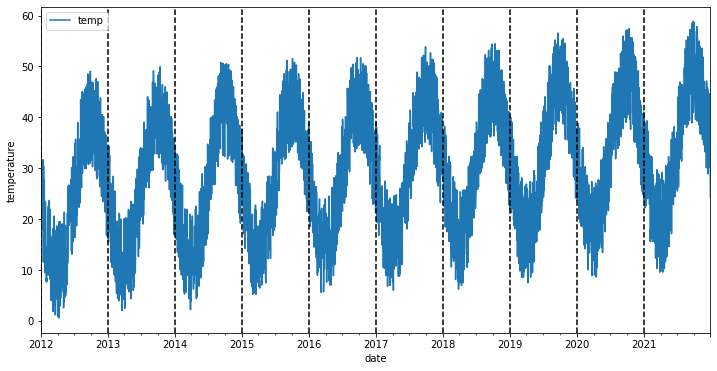

In [4]:
ax = df_orig.plot(x='date', y='temp', figsize=(12,6))
xcoords = ['2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01',
           '2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
ax.set_ylabel('temperature')

<font face="Times New Roman" size=4>    
    Before moving on to the next section, let’s take a moment to look at the data. Interestingly, the data seem to have a seasonal variation as the temperature increases in winter and decreases in summer (southern hemisphere). Also, the temperature does not seem to increase significantly over time since the mean temperature has almost the same value regardless of the year.</font>
    
---

* <font face="Times New Roman" size=5> Time-series Patterns </font><br>
<br>
<font face="Times New Roman" size=4> 
Time-series forecasting models use mathematical equation(s) to find patterns in a series of historical data. These equations are then used to project into the future the historical time patterns in the data.<br>
There are four types of time-series patterns:
    * Trend: Long-term increase or decrease in the data. The trend can be any function, such as linear or exponential, and can change direction over time.
    * Seasonality: Repeating cycle in the series with fixed frequencies (hour of the day, week, month, year, etc.). A seasonal pattern exists of a fixed known period.
    * Cyclicity: Occurs when the data rise and fall, but without a fixed frequency and duration caused, for example, by economic conditions.
    * Noise: The random variation in the series.<br>
<br>
Most time-series data will contain one or more patterns, but probably not all of them. Here there are some examples where we can identify some of these time-series patterns:<br>
    * Annual Wikipedia audience (Left figure): In this figure, we can identify an increasing trend, as the audience increases linearly each year.
    * Seasonality plot of US electricity usage (Middle figure): Each line corresponds to one year, so we can observe an annual seasonality as the consumption is repeated annually.
    * Daily closing of the IBEX 35 (Right figure): This time-series has an increasing trend over time, as well as a cyclical pattern since there are some periods in which the IBEX 35 decreased due to economical reasons.

![pic1](1.png)

<font face="Times New Roman" size=4> If we assume an additive decomposition for these patterns, we can write:

<center> Y[t] = T[t] + S[t] + e[t] </center>

where Y[t] is the data, T[t] is the trend-cycle component, S[t] is the seasonal component, and e[t] is the noise, all at period t.

On the other hand, a multiplicative decomposition would be written as:

<center> Y[t] = T[t] *S[t] *e[t] </center>

The additive decomposition is the most suitable one when the seasonal fluctuations do not vary with the level of the time-series. On the contrary, when the variation in the seasonal component appears to be proportional to the level of the time-series, then a multiplicative decomposition is more appropriate.</font>

---

* <font face="Times New Roman" size=5> Decompose the data </font><br>
<br>
<font face="Times New Roman" size=4> A stationary time-series is defined as a time-series whose properties do not depend on the time at which the series is observed. Thus, time-series with trends, or with seasonality, are not stationary whereas white noise series are stationary [[1]](https://f0nzie.github.io/hyndman-bookdown-rsuite/stationarity-and-differencing.html). In a more mathematical sense, a time-series is said to be stationary if it has a constant mean and variance and the covariance is independent of time. In [[1]](https://f0nzie.github.io/hyndman-bookdown-rsuite/stationarity-and-differencing.html), you have different illustrative examples that compare stationary vs non-stationary time-series. In general, a stationary time-series will not have long-term predictable patterns. <br>
But, why stationarity is important?<br>
Well, stationarity has become a common assumption for many practices and tools in time-series analysis. These include trend estimation, forecasting, and causal inference, among others. Therefore, in many cases, you will need to determine if the data was generated by a stationary process and transform it to have the properties of a sample generated by that process.<br>
But, how to check the stationary of time-series?<br>
We can check stationary in two ways. On the one hand, we can check it manually by checking the mean and variance of the time-series. On the other hand, we can assess stationarity using a test function.<br>
Some cases might be confusing. For example, a time-series without trend and seasonality but with cyclic behavior is stationary since the cycles are not of a fixed length.</font>


* <font face="Times New Roman" size=5> Checking the trend </font><br>
<br>
<font face="Times New Roman" size=4> To analyze the trend and seasonality of the time-series, we first analyze the mean over time using the rolling mean method with a 30-day and 365-day windows.</font>

TypeError: 'AxesSubplot' object is not subscriptable

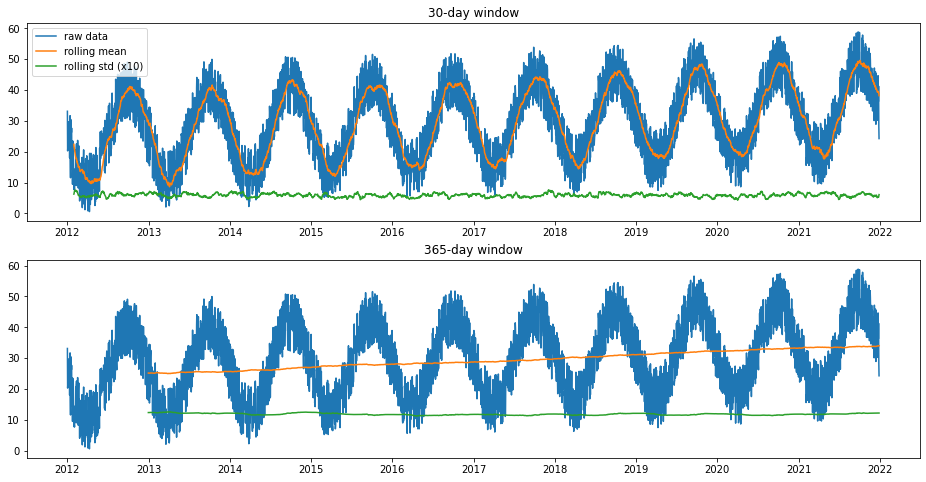

In [5]:
def analyze_stationarity(timeseries, title):
    fig, ax = plt.subplots(2, 1, figsize=(16, 8))

    rolmean = pd.Series(timeseries).rolling(window=30).mean() 
    rolstd = pd.Series(timeseries).rolling(window=30).std()
    ax[0].plot(timeseries, label= title)
    ax[0].plot(rolmean, label='rolling mean');
    ax[0].plot(rolstd, label='rolling std (x10)');
    ax[0].set_title('30-day window')
    ax[0].legend()
    
    rolmean = pd.Series(timeseries).rolling(window=365).mean() 
    rolstd = pd.Series(timeseries).rolling(window=365).std()
    ax[1].plot(timeseries, label= title)
    ax[1].plot(rolmean, label='rolling mean');
    ax[1].plot(rolstd, label='rolling std (x10)');
    ax[1].set_title('365-day window')
    
pd.options.display.float_format = '{:.8f}'.format
analyze_stationarity(df['temp'], 'raw data')
ax[1].legend()

<font face="Times New Roman" size=4>In the figure, we can see how the rolling mean when using a 30-day window oscillates over time caused of the seasonality pattern of the data. Also, the rolling mean when using the 365-day window increases over time, indicating a slightly increasing trend over time.<br>
This can also be assessed using several tests such as the Dickey-Fuller (ADF) and the Kwiatkowski, Phillips, Schmidt, and Shin (KPSS):<br>
The result of the ADF test (p-value below 0.05) suggests that the null hypothesis of the presence of a unit root can be rejected at a 95% confidence level. Hence, if the p-value is below 0.05, the time-series is stationary.<br>
The result of the KPSS test (p-value above 0.05) suggests that the null hypothesis of the absence of a unit root presence of unit root cannot be rejected at a 95% confidence level. Hence, if the p-value is below 0.05, the time-series is not stationary.<br>
Although these tests seem to be described to check the stationarity of the data, these are useful to analyze the trend of the time-series rather than the seasonality, as indicated in [[2]](https://stats.stackexchange.com/questions/225087/seasonal-data-deemed-stationary-by-adf-and-kpss-tests).

In [6]:
def ADF_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

ADF_test(df)

Results of Dickey-Fuller Test:
Test Statistic                  -2.59044301
p-value                          0.09498864
Lags Used                       13.00000000
Number of Observations Used   3637.00000000
Critical Value (1%)             -3.43214926
Critical Value (5%)             -2.86233501
Critical Value (10%)            -2.56719320
dtype: float64


In [7]:
def KPSS_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries.dropna(), regression="c", nlags="auto")    
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

KPSS_test(df)

Results of KPSS Test:
Test Statistic           1.11167991
p-value                  0.01000000
Lags Used               37.00000000
Critical Value (10%)     0.34700000
Critical Value (5%)      0.46300000
Critical Value (2.5%)    0.57400000
Critical Value (1%)      0.73900000
dtype: float64


/Users/zhouxingwei/opt/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


<font face="Times New Roman" size=4>Interestingly, the statistical results revealed an effect of the stationarity of the time-series. However, the null hypothesis for both tests is the opposite. While the ADF test indicates that the time-series is stationary (p-value > 0.05), the KPSS test reveals that it is not stationary (p-value > 0.05). This dataset was created with a slight trend, so results pinpoint that the KPSS test is more accurate for analyzing this dataset.<br>
To reduce the trend of the dataset, we could implement the following detrending method:</font>

Results of Dickey-Fuller Test:
Test Statistic                  -2.55840062
p-value                          0.10190337
Lags Used                       13.00000000
Number of Observations Used   3273.00000000
Critical Value (1%)             -3.43234952
Critical Value (5%)             -2.86242347
Critical Value (10%)            -2.56724029
dtype: float64


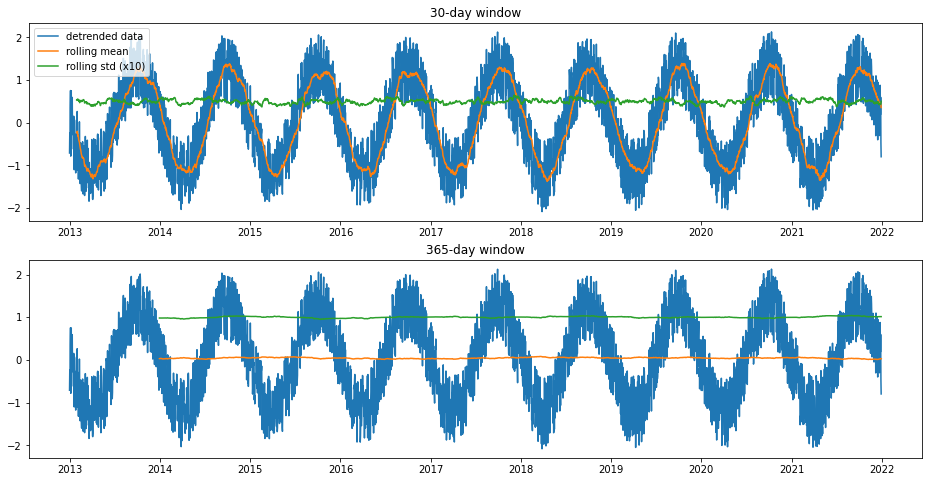

In [8]:
df_detrend = (df - df.rolling(window=365).mean()) / df.rolling(window=365).std()

analyze_stationarity(df_detrend['temp'].dropna(), 'detrended data')
ADF_test(df_detrend.dropna())

* <font face="Times New Roman" size=5> Checking the seasonality </font><br>
<br>
<font face="Times New Roman" size=4> As observed before from the rolling std, there is a seasonal pattern within our time-series. Hence, we should implement a differencing method to remove the underlying seasonal or cyclical patterns in the time-series. Since the sample dataset has a 12-month seasonality, I used a difference of 365-lag difference:</font>

Results of Dickey-Fuller Test:
Test Statistic                 -27.18597218
p-value                          0.00000000
Lags Used                        4.00000000
Number of Observations Used   3281.00000000
Critical Value (1%)             -3.43234464
Critical Value (5%)             -2.86242131
Critical Value (10%)            -2.56723914
dtype: float64


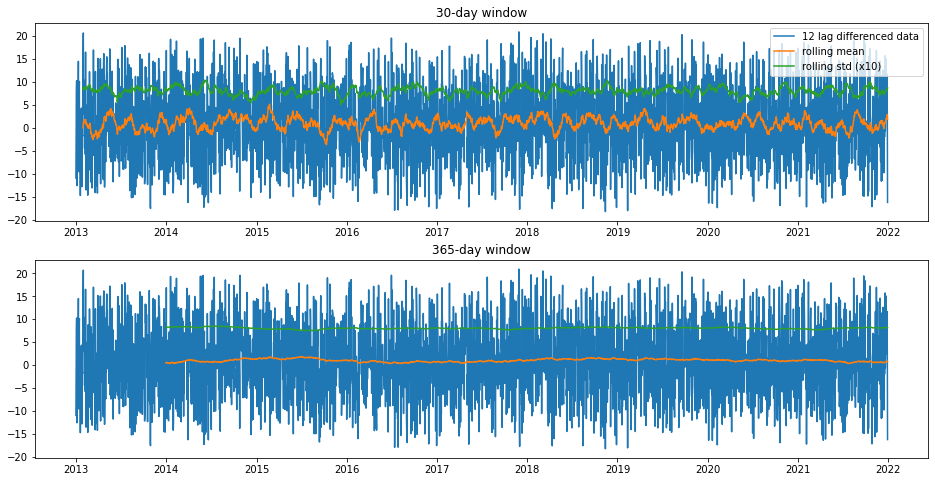

In [9]:
df_365lag =  df - df.shift(365)

analyze_stationarity(df_365lag['temp'].dropna(), '12 lag differenced data')
ADF_test(df_365lag.dropna())

<font face="Times New Roman" size=4>Now, both the rolling mean and std remain more or less constant over time, so we have a stationary time-series.<br>
The combined implementation of the detrending and differencing methods would be as follows:</font>

Results of Dickey-Fuller Test:
Test Statistic                 -25.23868751
p-value                          0.00000000
Lags Used                        4.00000000
Number of Observations Used   2917.00000000
Critical Value (1%)             -3.43259377
Critical Value (5%)             -2.86253135
Critical Value (10%)            -2.56729772
dtype: float64


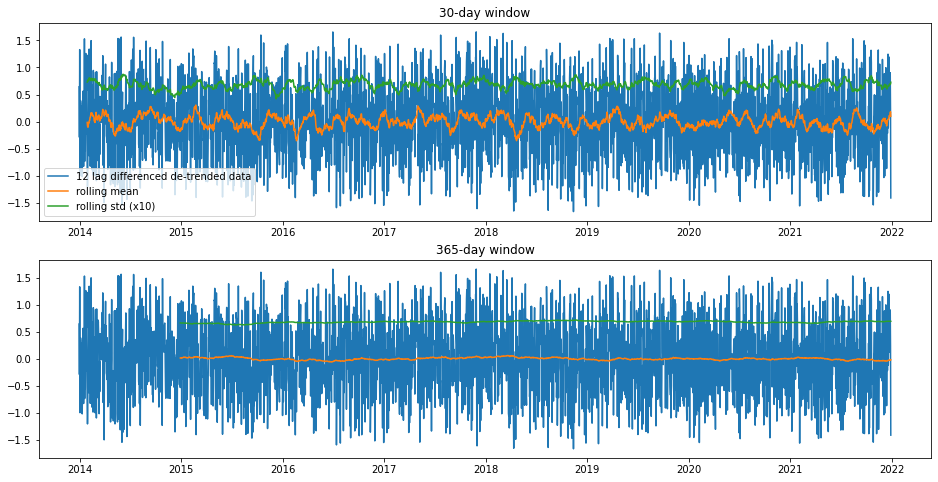

In [10]:
df_365lag_detrend =  df_detrend - df_detrend.shift(365)

analyze_stationarity(df_365lag_detrend['temp'].dropna(), '12 lag differenced de-trended data')
ADF_test(df_365lag_detrend.dropna())

* <font face="Times New Roman" size=5> Decomposition </font><br>
<br>
<font face="Times New Roman" size=4> The decomposition based on the mentioned patterns can be implemented with a useful Python function called seasonal_decompose within the 'statsmodels' package:</font>

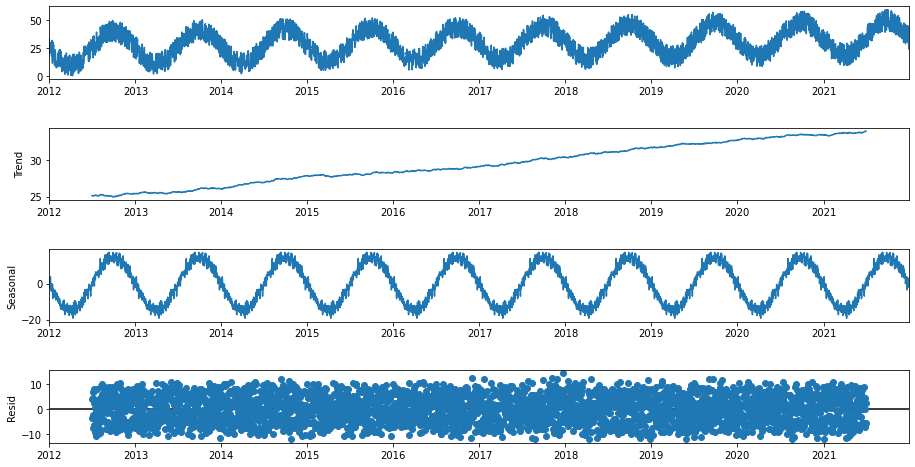

(date
 2012-01-01   NaN
 2012-01-02   NaN
 2012-01-03   NaN
 2012-01-04   NaN
 2012-01-05   NaN
               ..
 2021-12-25   NaN
 2021-12-26   NaN
 2021-12-27   NaN
 2021-12-28   NaN
 2021-12-29   NaN
 Name: trend, Length: 3651, dtype: float64,
 date
 2012-01-01    0.68925289
 2012-01-02   -0.18733507
 2012-01-03   -1.21639401
 2012-01-04    2.21413066
 2012-01-05   -2.36000832
                  ...    
 2021-12-25    2.50944601
 2021-12-26    0.25143749
 2021-12-27    2.89931390
 2021-12-28   -1.97373838
 2021-12-29    0.68925289
 Name: seasonal, Length: 3651, dtype: float64,
 date
 2012-01-01   NaN
 2012-01-02   NaN
 2012-01-03   NaN
 2012-01-04   NaN
 2012-01-05   NaN
               ..
 2021-12-25   NaN
 2021-12-26   NaN
 2021-12-27   NaN
 2021-12-28   NaN
 2021-12-29   NaN
 Name: resid, Length: 3651, dtype: float64)

In [15]:
def seasonal_decompose (df):
    decomposition = sm.tsa.seasonal_decompose(df, model='additive',period=365)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    fig = decomposition.plot()
    fig.set_size_inches(14, 7)
    plt.show()
    
    return trend, seasonal, residual
   
seasonal_decompose(df)

<font face="Times New Roman" size=4>After looking at the four parts of decomposed graphs, we can say that there is a strong component of annual seasonality in our time-series, as well as an increasing trend pattern over time.</font>

---

* <font face="Times New Roman" size=5> Modeling </font><br>
<br>
<font face="Times New Roman" size=4> The appropriate model for your time-series data will depend on the data’s particular characteristics, for example, if the dataset has an overall trend or seasonality. Please be sure to choose the model that best suits your data.<br>
The appropriate model for your time-series data will depend on the particular characteristics of the data such as trend and seasonality. Be sure to choose the model that best suits your data:<br>
  * Autoregression (AR)
  * Moving Average (MA)
  * Autoregressive Moving Average (ARMA)
  * Autoregressive Integrated Moving Average (ARIMA)
  * Seasonal Autoregressive Integrated Moving-Average (SARIMA)
  * Seasonal Autoregressive Integrated Moving-Average with Exogenous Regressors (SARIMAX)
  * Vector Autoregression (VAR)
  * Vector Autoregression Moving-Average (VARMA)
  * Vector Autoregression Moving-Average with Exogenous Regressors (VARMAX)
  * Simple Exponential Smoothing (SES)
  * Holt Winter’s Exponential Smoothing (HWES)<br>
  <br>
Since there was seasonality within our data, the implemented model has been the Holt-Winters’ Exponential Smoothing method as it is suitable for time-series data with the trend and/or seasonal components.<br>
This method uses exponential smoothing to encode lots of values from the past and use them to predict “typical” values for the present and future. Exponential smoothing refers to the use of an exponentially weighted moving average (EWMA) to “smooth” a time-series.</br>
Before implementing it, let’s create the training and testing datasets:</font>

In [21]:
y = df['temp'].astype(float)
y_to_train = y[:'2019-12-31']
y_to_val = y['2020-01-01':]
predict_date = len(y) - len(y[:'2019-12-31'])

<font face="Times New Roman" size=4>Here is the implementation using the root-mean-square error (RMSE) as the metric to assess the error of the model.</font>

/Users/zhouxingwei/opt/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


The Root Mean Squared Error of additive trend, additive seasonal of period season_length=365 and a Box-Cox transformation 6.1


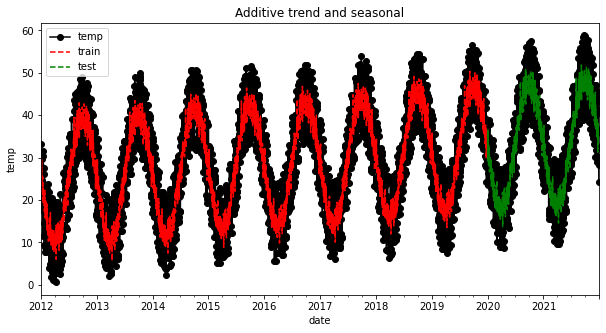

In [22]:
def holt_win_sea(y, y_to_train, y_to_test, seasonal_period, predict_date):
    
    fit1 = ExponentialSmoothing(y_to_train, seasonal_periods=seasonal_period, trend='add', seasonal='add').fit(use_boxcox=None)
    fcast1 = fit1.forecast(predict_date).rename('Additive')
    mse1 = ((fcast1 - y_to_test.values) ** 2).mean()
    print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
          'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))

    y.plot(marker='o', color='black', legend=True, figsize=(10, 5))
    fit1.fittedvalues.plot(style='--', color='red', label='train')
    fcast1.plot(style='--', color='green', label='test')
    plt.ylabel('temp')
    plt.title('Additive trend and seasonal')
    plt.legend()
    plt.show()
    
holt_win_sea(y, y_to_train, y_to_val, 365, predict_date)

<font face="Times New Roman" size=4>From the figure, we can observe how the model captures the seasonality and trend of the time-series, having an error in the prediction of the outliers.</font>

---

* <font face="Times New Roman" size=5> Conclusion </font><br>
<br>
<font face="Times New Roman" size=4> Understanding the main time-series patterns and learning how to implement time-series forecasting models is essential due to their many applications.<br>
Throughout this article, we have covered the trend and seasonality with a hands-on example based on a temperature dataset. Apart from checking the trend and seasonality, we have seen how to reduce it and how to create a basic model that uses these patterns to infer the temperature of the next few days.</font>